In [4]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets

import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import pandas as pd
from torch.autograd import Variable
import os
basedir=os.path.abspath(os.path.dirname('__file__'))
data_folder=os.path.join(basedir, 'data') # this is folder where the images are saved




batch_size = 28
n_iters = 3000


In [5]:
#taken from https://www.reddit.com/r/learnmachinelearning/comments/92nh4c/how_do_i_load_images_into_pytorch_for_training/
#images courtesy of Kaggle at - https://www.kaggle.com/drgfreeman/rockpaperscissors


def load_images(image_size=28, batch_size=batch_size, root=data_folder):

    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor()
#                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        
    ])

    train_set = datasets.ImageFolder(root=root, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    
    test_set= datasets.ImageFolder(root=root, transform=transform)
    test_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_set, train_loader, test_set, test_loader    

In [6]:



train_set, train_loader, test_set, test_loader  =load_images(image_size=28, batch_size=batch_size, root=data_folder)

num_epochs = n_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

0


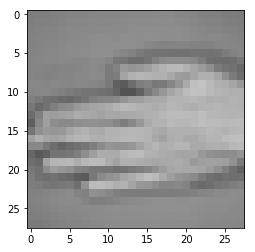

In [7]:
### a sample of the image ###

plt.imshow(train_set[0][0].permute(1, 2, 0)  )
print(train_set[0][1])

In [40]:
train_set.class_to_idx

{'paper': 0, 'rock': 1, 'scissors': 2}

In [8]:
test_set[0][0].numpy().shape

(3, 28, 28)

In [9]:
### calculating padding
height=28
width = 28
kernel_size = 5 # we
padding = int((kernel_size-1)/2)
stride=1

#output_after_1_convolution
out1=(height-kernel_size+(2*padding))/1 + 1 #=28

output_pool1 = out1/padding #=14


out2=(output_pool1-kernel_size+(2*padding))/1 + 1 #= 14

output_pool2 = out2/padding #=7

In [20]:
print(output_pool1)
print(output_pool2)

14.0
7.0


In [28]:
padding

2

In [21]:
(kernel_size-1)/2

2.0

14.0

In [27]:
32 * output_pool2 * output_pool2

1568.0

In [34]:



class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
    
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_size, stride=1, padding=padding)
        self.relu1 = nn.ReLU() 
        #inchannel = 1 because it is one grey scale #out_channels=number of kernels you're choosing ,so 16 feature maps
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #maxpool kernel = (kernel_size-1)/2 = (5-1)/2 = 2
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(int(32 * output_pool2 * output_pool2), 3) ## so out_channels * output pools, and 3 represents the number of labels (rock paper or scissors)
        
        # 32*7*7 = final conv output X output_pool2 X output_pool2
        # '10' refers to the labels len(torch.unique(test_dataset.test_labels)))
        
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [35]:
model = CNNModel()

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [36]:
print(model.parameters())

print('length of parameters :',len(list(model.parameters())))

# Convolution 1: 16 Kernels
print("\n first outout, first input , kernel dimensions :")
print(list(model.parameters())[0].size())

# Convolution 1 Bias: 16 Kernels
print(list(model.parameters())[1].size())

print("\n second outout, second input , kernel dimensions :")
# Convolution 2: 32 Kernels with depth = 16
print(list(model.parameters())[2].size())

# Convolution 2 Bias: 32 Kernels with depth = 16

print(list(model.parameters())[3].size())

# Fully Connected Layer 1

print('\nnumber of labels=3, 1569= 32*7*7 as per max pooling calcs above')
print(list(model.parameters())[4].size())

# Fully Connected Layer Bias
print(list(model.parameters())[5].size())

<generator object Module.parameters at 0x1241669a8>
length of parameters : 6

 first outout, first input , kernel dimensions :
torch.Size([16, 3, 5, 5])
torch.Size([16])

 second outout, second input , kernel dimensions :
torch.Size([32, 16, 5, 5])
torch.Size([32])

number of labels=3, 1569= 32*7*7 as per max pooling calcs above
torch.Size([3, 1568])
torch.Size([3])


In [38]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images
        images = images.requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images
                images = images.requires_grad_()
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

KeyboardInterrupt: 

## Testing One Single Image

In [ ]:
### Testing from a Single Image taken from the dataset


test_image=test_set[0][0]
printing_image=test_image
test_image = Variable(test_image, requires_grad=True)
test_image = test_image.unsqueeze(0)
outputs=model(test_image)
print(outputs[0,:])
print('\n predicted Label is :')
print(torch.max(outputs.data, 1)[1][0])
pred_label=int(torch.max(outputs.data, 1)[1][0])

if pred_label == 0:
    print("predicted label is Paper")
elif pred_label == 1:
    print("predicted label is Rock")
else:
    print("predicted label is Scissors")

print('\n correct label is ')
print(test_set[0][1])

actual_label=test_set[0][1]

if actual_label == 0:
    print("actual label is Paper")
elif actual_label == 1:
    print("actual label is Rock")
else:
    print("actual label is Scissors")



if (torch.max(outputs.data, 1)[1][0])==(test_set[0][1]):
    print("\n correct Pred")
else:
    print("better luck nekk time")
    
    
plt.imshow(printing_image.detach().permute(1, 2, 0))

In [335]:
## saving model and dataset

save_model = False
if save_model is True:
    # Saves only parameters
    # alpha & beta
    torch.save(model.state_dict(), "RPSclass.pth")

